<a href="https://colab.research.google.com/github/MrGanja890/Mr.-Nobodies-public-/blob/main/stock_price_prediction_random_forest_yfinance_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Processing AAPL ...


/tmp/ipython-input-1441283976.py:113: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(sym, start=start_date, end=end_date, progress=False)


  Next-day predicted price range (USD): $221.22 to $235.10
  Next-day predicted price range (EUR): €205.73 to €218.64
  Next-day predicted price range (INR): ₹18139.84 to ₹19278.06


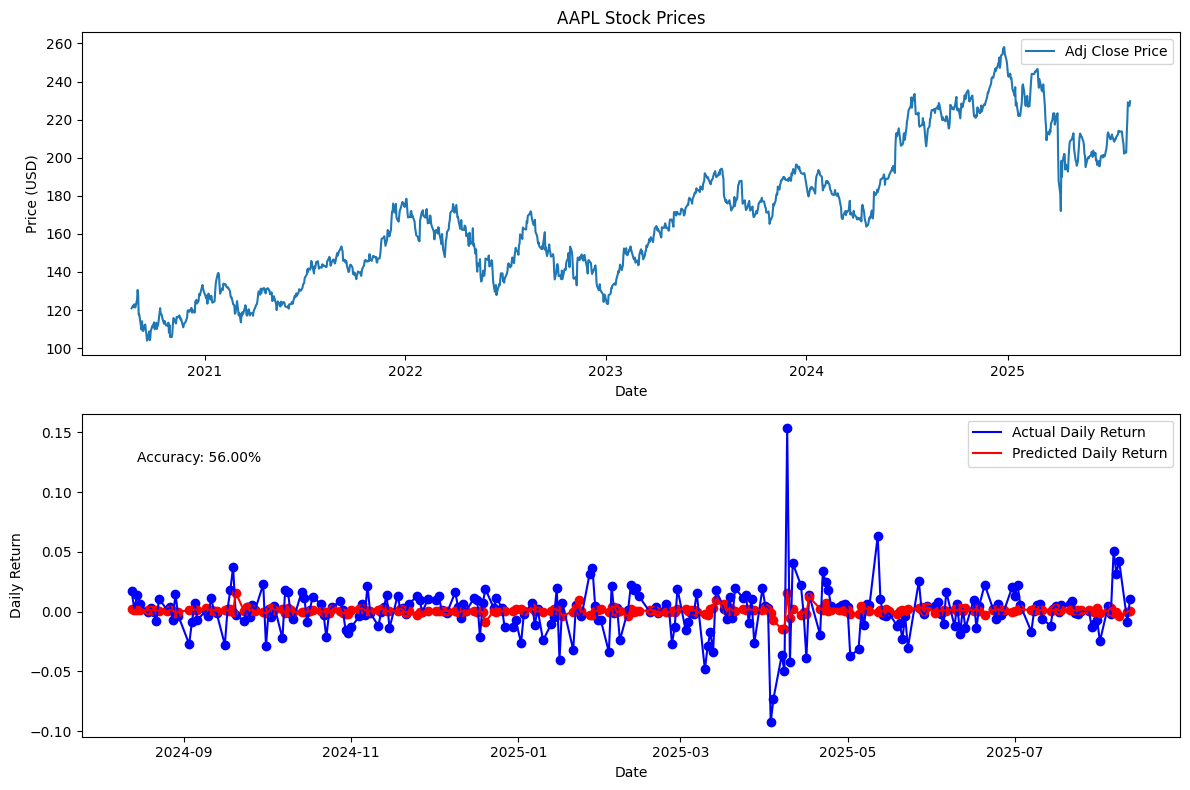


Processing MSFT ...


/tmp/ipython-input-1441283976.py:113: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(sym, start=start_date, end=end_date, progress=False)


  Next-day predicted price range (USD): $521.88 to $550.13
  Next-day predicted price range (EUR): €485.35 to €511.62
  Next-day predicted price range (INR): ₹42794.21 to ₹45110.79


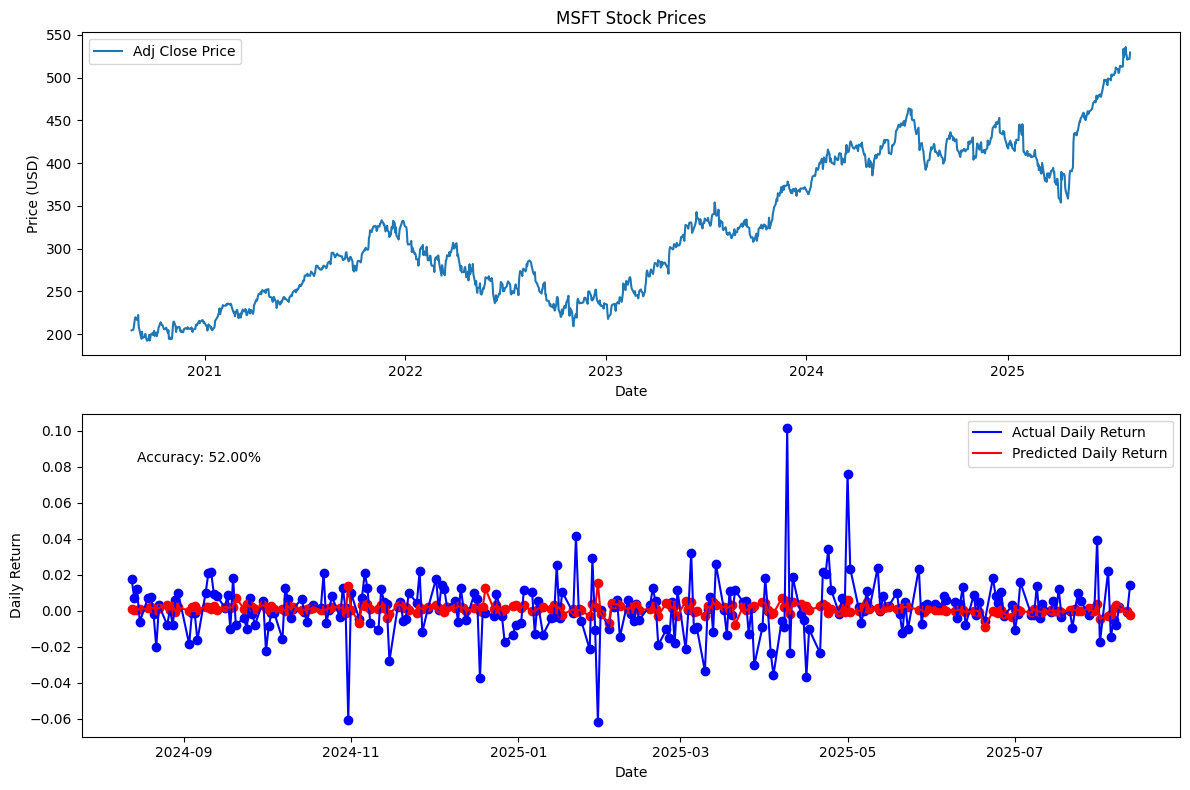


PREDICTION SUMMARY:
+-------+--------+----------+-------------------+-------------------+-----------------------+
| Stock |  MSE   | Accuracy |   Next Day (USD)  |   Next Day (EUR)  |     Next Day (INR)    |
+-------+--------+----------+-------------------+-------------------+-----------------------+
|  AAPL | 0.0004 |  56.00%  | $221.22 - $235.10 | €205.73 - €218.64 | ₹18139.84 - ₹19278.06 |
|  MSFT | 0.0003 |  52.00%  | $521.88 - $550.13 | €485.35 - €511.62 | ₹42794.21 - ₹45110.79 |
+-------+--------+----------+-------------------+-------------------+-----------------------+

Summary DataFrame (for your reference):
symbol    mse accuracy      next_day_usd      next_day_eur          next_day_inr
  AAPL 0.0004   56.00% $221.22 - $235.10 €205.73 - €218.64 ₹18139.84 - ₹19278.06
  MSFT 0.0003   52.00% $521.88 - $550.13 €485.35 - €511.62 ₹42794.21 - ₹45110.79


In [21]:
# ===== STEP 1: BASE ANALYSIS =====
# Installs (safe to re-run)
!pip install -q yfinance scikit-learn prettytable python-dateutil python-docx

# Inline plotting in notebooks (Colab/Jupyter)
%matplotlib inline

# Imports
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import time
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
from prettytable import PrettyTable

# --- Currency conversion rates (approx; we print currency words, not symbols) ---
CONVERSION_RATE_EUR = 0.93   # 1 USD ≈ 0.93 EUR <== adjust the rate as needed
CONVERSION_RATE_INR = 82.0   # 1 USD ≈ 82 INR  <== adjust the rate as needed source: https://www.xe.com/en/currencyconverter/convert/?Amount=1&From=USD&To=INR

# ---------- Helpers ----------
def calculate_daily_returns(stock_data):
    if 'Adj Close' not in stock_data.columns:
        if 'Close' in stock_data.columns:
            stock_data['Adj Close'] = stock_data['Close']
        else:
            raise KeyError("Neither 'Adj Close' nor 'Close' available in data")
    stock_data['Daily Return'] = stock_data['Adj Close'].pct_change()
    stock_data.dropna(inplace=True)
    return stock_data

def create_lag_features(stock_data, num_days=5):
    for i in range(1, num_days+1):
        stock_data[f'lag_{i}'] = stock_data['Daily Return'].shift(i)
    stock_data.dropna(inplace=True)
    return stock_data

def train_random_forest_model(X_train, y_train):
    model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
    model.fit(X_train, y_train)
    return model

def evaluate_model(stock_symbol, X_test, y_test, predictions, stock_data):
    mse = mean_squared_error(y_test, predictions)
    acc = accuracy_score(np.sign(y_test), np.sign(predictions))

    # --- Next Day Prediction using entire historical data ---
    model_all = train_random_forest_model(stock_data.drop(['Daily Return'], axis=1), stock_data['Daily Return'])
    last_features = stock_data.drop(['Daily Return'], axis=1).iloc[-1].values.reshape(1, -1)
    tree_preds = [estimator.predict(last_features)[0] for estimator in model_all.estimators_]
    predicted_return_range = (min(tree_preds), max(tree_preds))
    last_adj_close = stock_data['Adj Close'].iloc[-1]
    if isinstance(last_adj_close, pd.Series):
        last_adj_close = last_adj_close.iloc[0]
    last_adj_close = float(last_adj_close)
    next_day_range_usd = (last_adj_close * (1 + predicted_return_range[0]),
                          last_adj_close * (1 + predicted_return_range[1]))
    next_day_range_eur = (next_day_range_usd[0] * CONVERSION_RATE_EUR,
                          next_day_range_usd[1] * CONVERSION_RATE_EUR)
    next_day_range_inr = (next_day_range_usd[0] * CONVERSION_RATE_INR,
                          next_day_range_usd[1] * CONVERSION_RATE_INR)


    print(f"  Next-day predicted price range (USD): ${next_day_range_usd[0]:.2f} to ${next_day_range_usd[1]:.2f}")
    print(f"  Next-day predicted price range (EUR): €{next_day_range_eur[0]:.2f} to €{next_day_range_eur[1]:.2f}")
    print(f"  Next-day predicted price range (INR): ₹{next_day_range_inr[0]:.2f} to ₹{next_day_range_inr[1]:.2f}")


    return mse, acc, next_day_range_usd, next_day_range_eur, next_day_range_inr

def save_plot(stock_symbol, hist_data, y_test, predictions, acc, filename):
    plt.figure(figsize=(12,8))
    # Top subplot: historical stock prices
    plt.subplot(2,1,1)
    plt.plot(hist_data.index, hist_data['Adj Close'], label='Adj Close Price')
    plt.title(f'{stock_symbol} Stock Prices')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    # Bottom subplot: actual vs. predicted daily returns
    plt.subplot(2,1,2)
    plt.plot(y_test.index, y_test, color='blue', label='Actual Daily Return')
    plt.plot(y_test.index, predictions, color='red', label='Predicted Daily Return')
    plt.scatter(y_test.index, y_test, color='blue')
    plt.scatter(y_test.index, predictions, color='red')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.legend()
    plt.annotate(f'Accuracy: {acc*100:.2f}%', xy=(0.05, 0.85), xycoords='axes fraction')
    plt.tight_layout()
    plt.savefig(filename)
    plt.show() # Display the plot in the output cell.
    plt.close()


# -------- Run analysis on your chosen tickers --------
# You can add more symbols here later, e.g. ["AAPL", "MSFT", "NVDA"]
stock_list = ["AAPL", "MSFT"] #<====Add more stocks symbols here

all_results = []
for sym in stock_list:
    print(f"\nProcessing {sym} ...")
    end_date = datetime.today().strftime("%Y-%m-%d")
    start_date = (datetime.today() - relativedelta(years=5)).strftime("%Y-%m-%d")
    attempts = 0
    stock_data = None
    while attempts < 3:
        try:
            stock_data = yf.download(sym, start=start_date, end=end_date, progress=False)
            break
        except Exception as e:
            print(f"Download error for {sym} (attempt {attempts+1}): {e}")
            attempts += 1
            time.sleep(5)

    if stock_data is None or stock_data.empty:
        print(f"  -> No data for {sym}, skipping.")
        continue

    stock_data = calculate_daily_returns(stock_data)
    stock_data = create_lag_features(stock_data, num_days=5)

    X = stock_data.drop(['Daily Return'], axis=1)
    y = stock_data['Daily Return']

    if X.empty or y.empty:
        print(f"  -> Not enough data for {sym}, skipping.")
        continue

    # Time-series split (no shuffle)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model = train_random_forest_model(X_train, y_train)
    preds = model.predict(X_test)

    mse, acc, next_day_usd, next_day_eur, next_day_inr = evaluate_model(sym, X_test, y_test, preds, stock_data)

    # Save individual stock plot
    save_plot(sym, stock_data, y_test, preds, acc, f"{sym}_stock_graph.png")

    all_results.append({
        "symbol": sym,
        "mse": mse,
        "accuracy": acc,
        "next_day_usd": next_day_usd,
        "next_day_eur": next_day_eur,
        "next_day_inr": next_day_inr,
        "adj_close_series": (stock_data.index, stock_data['Adj Close']) # Keep this for potential future use or combined plot if needed later
    })

    time.sleep(1)


if not all_results:
    raise SystemExit("No valid predictions were made. Please try with different tickers.")

# Build DataFrames for display & export
summary_df_raw, summary_df = create_results_dataframe(all_results)


# ---- Print a neat table to the terminal output ----
pt = PrettyTable()
pt.field_names = ["Stock", "MSE", "Accuracy", "Next Day (USD)", "Next Day (EUR)", "Next Day (INR)"]
for r in all_results:
    usd = r["next_day_usd"]; eur = r["next_day_eur"]; inr = r["next_day_inr"]
    pt.add_row([
        r["symbol"],
        f"{r['mse']:.4f}",
        f"{r['accuracy']*100:.2f}%",
        f"${usd[0]:.2f} - ${usd[1]:.2f}",
        f"€{eur[0]:.2f} - €{eur[1]:.2f}",
        f"₹{inr[0]:.2f} - ₹{inr[1]:.2f}",
    ])
print("\nPREDICTION SUMMARY:")
print(pt)

# Also show the DataFrame version (same info)
print("\nSummary DataFrame (for your reference):")
print(summary_df.to_string(index=False))

# Keep these variables for Step 2:
results = all_results            # list of dicts (for export)
summary_dataframe_display = summary_df  # pretty version (just for your reference)

In [ ]:
# ===== STEP 2: WORD REPORT (asks & downloads) =====
from docx import Document
from docx.shared import Inches
from google.colab import files
import os

def create_results_dataframe_for_export(results):
    # Same formatting used in Step 1
    import pandas as pd
    df = pd.DataFrame(results)[["symbol", "mse", "accuracy",
                                "next_day_usd", "next_day_eur", "next_day_inr"]]
    df_disp = df.copy()
    df_disp["mse"] = df_disp["mse"].map(lambda x: f"{x:.4f}")
    df_disp["accuracy"] = df_disp["accuracy"].map(lambda x: f"{x*100:.2f}%")
    df_disp["next_day_usd"] = df_disp["next_day_usd"].map(lambda r: f"{r[0]:.2f} USD - {r[1]:.2f} USD")
    df_disp["next_day_eur"] = df_disp["next_day_eur"].map(lambda r: f"{r[0]:.2f} EUR - {r[1]:.2f} EUR")
    df_disp["next_day_inr"] = df_disp["next_day_inr"].map(lambda r: f"{r[0]:.2f} INR - {r[1]:.2f} INR")
    return df_disp

def generate_word_with_dataframe(results, output_filename="Stock_Report.docx"):
    df = create_results_dataframe_for_export(results)
    doc = Document()

    # Title
    doc.add_heading('Stock Prediction Report', level=1)

    # Include individual graph images, one per paragraph
    doc.add_paragraph("Stock Price and Daily Return Graphs:")
    for result in results:
        symbol = result["symbol"]
        filename = f"{symbol}_stock_graph.png"
        if os.path.exists(filename):
            doc.add_picture(filename, width=Inches(6)) # Revert to original width
        else:
             doc.add_paragraph(f"(Graph for {symbol} not found; run Step 1 first to generate {filename})")

    doc.add_paragraph("Note: Price ranges are printed with currency names (USD, EUR, INR).")

    # Table (with borders via 'Table Grid' style)
    table = doc.add_table(rows=1, cols=len(df.columns))
    table.style = 'Table Grid'

    # Header row
    hdr_cells = table.rows[0].cells
    for i, col in enumerate(df.columns):
        hdr_cells[i].text = col

    # Data rows
    for _, row in df.iterrows():
        row_cells = table.add_row().cells
        for i, val in enumerate(row):
            row_cells[i].text = str(val)

    # Save file
    doc.save(output_filename)
    return output_filename

def export_word_report(results):
    choice = input("Do you want to download the Word report? (yes/no): ").strip().lower()
    if choice == "yes":
        print("Preparing Word report...")
        filename = generate_word_with_dataframe(results)
        print("Starting download...")
        files.download(filename)   # Triggers browser download in Colab
        print("Downloaded Word report.")
    else:
        print("Download skipped.")

# Call it using the 'results' produced in Step 1:
export_word_report(results)

Do you want to download the Word report? (yes/no): yes
Preparing Word report...
Starting download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded Word report.
